<a href="https://colab.research.google.com/github/Pratik4321/Legendary-Pokemon-Classification-Using-DNNs/blob/main/Legendary_Pokemon_Classification_Using_DNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Load and preprocess the data
df = pd.read_csv("/content/drive/MyDrive/Pokemon.csv")
df = df.drop(columns=["#", "Name"])

# Encode categorical columns
for col in ["Type 1", "Type 2", "Generation"]:
    df[col] = df[col].astype(str)
    df[col] = LabelEncoder().fit_transform(df[col])

# Convert target
df["Legendary"] = df["Legendary"].astype(int)

# Features and target
X = df.drop(columns=["Legendary"])
y = df["Legendary"]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [ ]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )

    def forward(self, x):
        return torch.relu(self.block(x) + x)

# ResNet DNN for Tabular Data
class ResNetTabular(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, 64)
        self.res1 = ResidualBlock(64)
        self.res2 = ResidualBlock(64)
        self.final = nn.Sequential(
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.input_layer(x)
        x = self.res1(x)
        x = self.res2(x)
        return self.final(x)

In [ ]:
# Instantiate model
model = ResNetTabular(input_dim=X.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

# Early stopping setup
best_val_loss = float('inf')
patience = 10
counter = 0
best_model_state = None

In [ ]:
# Training loop
epochs = 1000
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_preds = model(X_train_tensor)
    train_loss = criterion(train_preds, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_tensor)
        val_loss = criterion(val_preds, y_val_tensor)
        val_pred_labels = (val_preds >= 0.5).int()
        val_acc = accuracy_score(y_val_tensor, val_pred_labels)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break


Epoch 001/1000 | Train Loss: 0.6431 | Val Loss: 0.6247 | Val Acc: 0.9219
Epoch 002/1000 | Train Loss: 0.6289 | Val Loss: 0.6096 | Val Acc: 0.9219
Epoch 003/1000 | Train Loss: 0.6122 | Val Loss: 0.5946 | Val Acc: 0.9219
Epoch 004/1000 | Train Loss: 0.5986 | Val Loss: 0.5797 | Val Acc: 0.9219
Epoch 005/1000 | Train Loss: 0.5836 | Val Loss: 0.5649 | Val Acc: 0.9219
Epoch 006/1000 | Train Loss: 0.5677 | Val Loss: 0.5499 | Val Acc: 0.9219
Epoch 007/1000 | Train Loss: 0.5564 | Val Loss: 0.5347 | Val Acc: 0.9219
Epoch 008/1000 | Train Loss: 0.5423 | Val Loss: 0.5191 | Val Acc: 0.9219
Epoch 009/1000 | Train Loss: 0.5260 | Val Loss: 0.5031 | Val Acc: 0.9219
Epoch 010/1000 | Train Loss: 0.5069 | Val Loss: 0.4865 | Val Acc: 0.9219
Epoch 011/1000 | Train Loss: 0.4956 | Val Loss: 0.4694 | Val Acc: 0.9219
Epoch 012/1000 | Train Loss: 0.4750 | Val Loss: 0.4516 | Val Acc: 0.9219
Epoch 013/1000 | Train Loss: 0.4605 | Val Loss: 0.4333 | Val Acc: 0.9219
Epoch 014/1000 | Train Loss: 0.4443 | Val Loss: 0.4

In [ ]:
# Load best model
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [ ]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)
    test_pred_labels = (test_preds >= 0.5).int()
    test_acc = accuracy_score(y_test_tensor, test_pred_labels)
    print("\nTest Accuracy:", test_acc)
    print(classification_report(y_test_tensor, test_pred_labels))


Test Accuracy: 0.93125
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       147
         1.0       0.62      0.38      0.48        13

    accuracy                           0.93       160
   macro avg       0.79      0.68      0.72       160
weighted avg       0.92      0.93      0.92       160



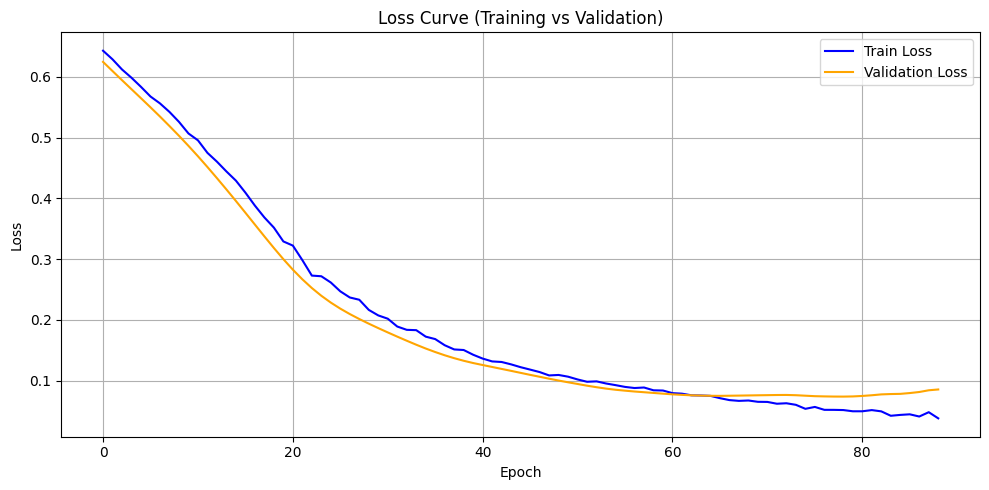

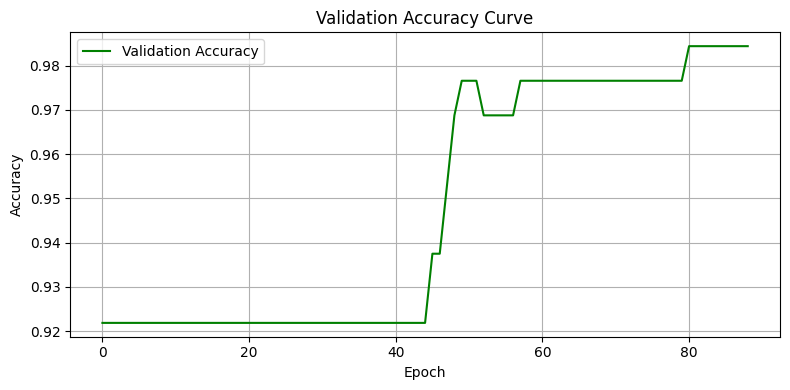

In [ ]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Training vs Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("resnet_dnn_loss_curve.png")
plt.show()

# Plot validation accuracy
plt.figure(figsize=(8, 4))
plt.plot(val_accuracies, label="Validation Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("resnet_dnn_val_accuracy.png")
plt.show()

In [ ]:
class ShallowNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class DeepDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

def train_and_evaluate(model, name, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    epochs = 50

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train_tensor)
        loss = criterion(preds, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_preds = model(X_test_tensor)
        test_labels = (test_preds >= 0.5).int()
        acc = accuracy_score(y_test_tensor, test_labels)
        print(f"{name} Test Accuracy: {acc:.4f}")
        return acc


In [ ]:
# Initialize models
shallow = ShallowNN(input_dim=X.shape[1])
deep = DeepDNN(input_dim=X.shape[1])
resnet = ResNetTabular(input_dim=X.shape[1])  # Your ResNet class

# Train and evaluate PyTorch models
nn_results = {
    "Shallow NN": train_and_evaluate(shallow, "Shallow NN", X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor),
    "Deep DNN": train_and_evaluate(deep, "Deep DNN", X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor),
    "ResNet DNN": train_and_evaluate(resnet, "ResNet DNN", X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor),
}


Shallow NN Test Accuracy: 0.9187
Deep DNN Test Accuracy: 0.9187
ResNet DNN Test Accuracy: 0.9250


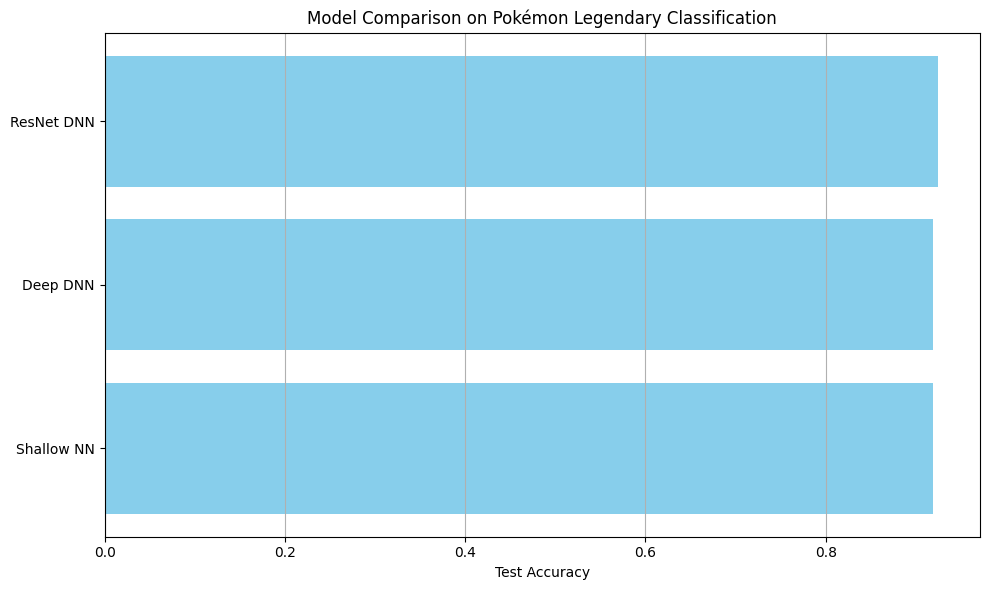

In [ ]:
# Merge all results
all_results = {**nn_results}

# Plot
plt.figure(figsize=(10, 6))
plt.barh(list(all_results.keys()), list(all_results.values()), color='skyblue')
plt.xlabel("Test Accuracy")
plt.title("Model Comparison on Pokémon Legendary Classification")
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()
